In [2]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [34]:
df_train = pd.read_csv('complex-master-learn-and-get-your-mark/train.csv')
df_test = pd.read_csv('complex-master-learn-and-get-your-mark/test.csv')

df_train.head()

,Id,PreferedAlbum,Vinyl,AvgTime,TicketInfo,Opinion,Concert,Age,VIP,Food,Drinks,FreePass
0,01/2362,Head Hunters,False,3.055,B/140/N,"Everything worked, yet nothing surprised me. (...",NYC12-5pm,22.0,False,170.0,1.0,True
1,04/0599,Bright Size Life,True,2.510,LB/124/N,"Solid gig—nothing magical, nothing awful. (NYC...",NYC12-5pm,9.0,False,0.0,0.0,True
2,01/3223,Head Hunters,False,0.803,CB/523/N,"Guitars were sharp, but everything else felt r...",NYC12-5pm,NaN,False,815.0,37.0,False
3,01/1966,Kind of Blue,False,0.568,A/81/XL,Feedback screamed louder than the guitars. Dis...,FL16-7pm,36.0,False,1427.0,1395.0,False
4,01/8850,Bright Size Life,False,0.034,B/580/XL,NaN,NYC12-5pm,16.0,False,1299.0,0.0,False


In [36]:
df=df_train.copy()

<Axes: xlabel='FreePass', ylabel='AvgTime'>

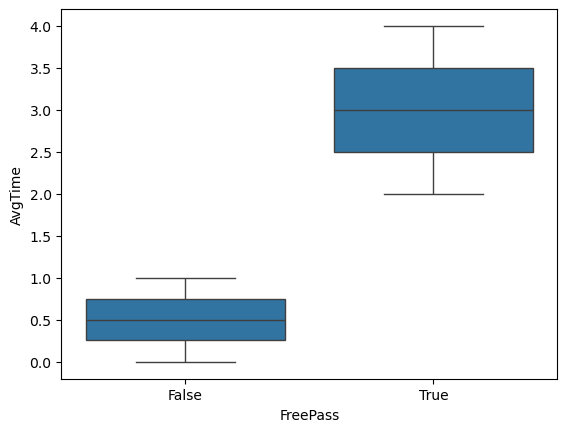

In [37]:
df.groupby(df["AvgTime"] > 2)["FreePass"].mean()
import seaborn as sns
sns.boxplot(x="FreePass", y="AvgTime", data=df)


In [ ]:
X = df.drop(columns=["Id", "FreePass"])
y = df["FreePass"].astype(int)

num_cols = X.select_dtypes(include="float64").columns
cat_cols = X.select_dtypes(include="object").columns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

clf_logreg = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

from sklearn.ensemble import RandomForestClassifier

clf_rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_leaf=100,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
))
])



In [130]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# =====================
# 1. Feature engineering
# =====================
X_fe = X.copy()

# Interacciones simples (mejoran LR)
X_fe["Food_Drinks"] = X_fe["Food"] + X_fe["Drinks"]
X_fe["Spending"] = X_fe["Food"] * X_fe["Drinks"]

# Quitamos la variable con leakage
X_fe = X_fe.drop(columns=["AvgTime"])

# =====================
# 2. Columnas
# =====================
X_fe['Age'] = X_fe['Age'].fillna(X_fe['Age'].median())
X_fe['Age_Group'] = pd.cut(X_fe['Age'], 
                          bins=[0, 25, 35, 45, 55, 100],
                          labels=['<25', '25-35', '35-45', '45-55', '55+'])
X_fe['Is_Young'] = (X_fe['Age'] < 30).astype(int)
X_fe['Is_Senior'] = (X_fe['Age'] > 50).astype(int)



# 5. Opinion simple
X_fe['Opinion_Length'] = X_fe['Opinion'].str.len().fillna(0)
X_fe['Has_Opinion'] = X_fe['Opinion'].notna().astype(int)


# Sentimiento básico
def simple_sentiment(text):
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    
    pos_words = ['good', 'great', 'excellent', 'amazing', 'love', 'best', 'awesome', 'perfect', 'fantastic']
    neg_words = ['bad', 'worst', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'boring', 'waste']
    
    pos_count = sum(1 for word in pos_words if word in text_lower)
    neg_count = sum(1 for word in neg_words if word in text_lower)
    
    if pos_count > neg_count:
        return 1
    elif neg_count > pos_count:
        return -1
    else:
        return 0

X_fe['Sentiment'] = X['Opinion'].apply(simple_sentiment)
X_fe['Sentiment_Score'] = X_fe['Sentiment'].astype(int)


# ========= TicketInfo parsing =========
X_fe["Ticket_Zone"] = X["TicketInfo"].str.split("/").str[0]
X_fe["Ticket_Row"] = X["TicketInfo"].str.split("/").str[1].astype(float)
X_fe["Ticket_Size"] = X["TicketInfo"].str.split("/").str[2]
X_fe['Is_Front_Row'] = (X_fe['Ticket_Row'] <= 10).astype(int)

for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size']:
    X_fe[col] = X_fe[col].fillna('Unknown')

for col in X_fe.columns:
    if X_fe[col].dtype == 'bool':
        X_fe[col] = X_fe[col].astype(int)


num_cols = X_fe.select_dtypes("float64").columns
cat_cols = X_fe.select_dtypes("object").columns

# =====================
# 3. Pipelines (LOS TUYOS, sin cambiar filosofía)
# =====================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=20   # reduce ruido de categorías raras
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(
    LogisticRegression(penalty="l1", solver="saga", C=0.1)
)


# =====================
# 4. Modelo
# =====================
clf = Pipeline([
    ("prep", preprocessor),
    ("selector", selector),
    ("model", LogisticRegression(
        max_iter=3000,
        solver="saga",
        penalty="l1",
        class_weight="balanced",
        n_jobs=-1
    ))
])

from sklearn.ensemble import HistGradientBoostingClassifier

clf_gb = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=300,
        class_weight="balanced"
    ))
])


# =====================
# 5. Train / validation
# =====================
X_train, X_val, y_train, y_val = train_test_split(
    X_fe,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf.fit(X_train, y_train)

# =====================
# 6. Threshold óptimo
# =====================
y_probs = clf.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)
scores = [f1_score(y_val, y_probs > t) for t in thresholds]

best_threshold = thresholds[np.argmax(scores)]
best_score = max(scores)

print("Best threshold:", best_threshold)
print("Best F1:", best_score)


c:\Users\anica\anaconda33\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best threshold: 0.4099999999999998
Best F1: 0.8033866415804327


In [138]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import numpy as np
import pandas as pd

# =====================
# 1. Feature engineering (TU VERSIÓN)
# =====================
X_fe = X.copy()

# Interacciones simples (mejoran LR)
X_fe["Food_Drinks"] = X_fe["Food"] + X_fe["Drinks"]
X_fe["Spending"] = X_fe["Food"] * X_fe["Drinks"]

# Quitamos la variable con leakage
X_fe = X_fe.drop(columns=["AvgTime"])

# =====================
# 2. Columnas
# =====================
X_fe['Age'] = X_fe['Age'].fillna(X_fe['Age'].median())
X_fe['Age_Group'] = pd.cut(X_fe['Age'], 
                          bins=[0, 25, 35, 45, 55, 100],
                          labels=['<25', '25-35', '35-45', '45-55', '55+'])
X_fe['Is_Young'] = (X_fe['Age'] < 30).astype(int)
X_fe['Is_Senior'] = (X_fe['Age'] > 50).astype(int)

# Opinion features
X_fe['Opinion_Length'] = X_fe['Opinion'].str.len().fillna(0)
X_fe['Has_Opinion'] = X_fe['Opinion'].notna().astype(int)

# Sentimiento básico
def simple_sentiment(text):
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    
    pos_words = ['good', 'great', 'excellent', 'amazing', 'love', 'best', 'awesome', 'perfect', 'fantastic']
    neg_words = ['bad', 'worst', 'terrible', 'awful', 'hate', 'disappointing', 'poor', 'boring', 'waste']
    
    pos_count = sum(1 for word in pos_words if word in text_lower)
    neg_count = sum(1 for word in neg_words if word in text_lower)
    
    if pos_count > neg_count:
        return 1
    elif neg_count > pos_count:
        return -1
    else:
        return 0

X_fe['Sentiment'] = X['Opinion'].apply(simple_sentiment)
X_fe['Sentiment_Score'] = X_fe['Sentiment'].astype(int)

# TicketInfo parsing
X_fe["Ticket_Zone"] = X["TicketInfo"].str.split("/").str[0]
X_fe["Ticket_Row"] = X["TicketInfo"].str.split("/").str[1].astype(float)
X_fe["Ticket_Size"] = X["TicketInfo"].str.split("/").str[2]
X_fe['Is_Front_Row'] = (X_fe['Ticket_Row'] <= 10).astype(int)

# Añadir más features de ticket
X_fe['Is_VIP_Zone'] = X_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)

# Imputar valores faltantes
# for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size', 'Age_Group']:
#     X_fe[col] = X_fe[col].fillna('Unknown')

# for col in ['Vinyl', 'VIP']:
#     X_fe[col] = X_fe[col].fillna('Unknown')

# Asegurar tipos
for col in X_fe.columns:
    if X_fe[col].dtype == 'bool':
        X_fe[col] = X_fe[col].astype(int)

# =====================
# 3. Pipelines CORREGIDOS (matriz densa)
# =====================
num_cols = X_fe.select_dtypes("float64").columns
cat_cols = X_fe.select_dtypes("object").columns

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# OneHotEncoder CON sparse_output=False para matriz densa
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        min_frequency=20,
        sparse_output=False  # <--- ESTA ES LA CLAVE
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# =====================
# 4. PROBAR MODELOS (todos compatibles con matrices densas)
# =====================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Dividir datos
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

# =====================
# MODELO 1: Random Forest (funciona bien)
# =====================
print("=" * 60)
print("MODELO 1: Random Forest")
print("=" * 60)

clf_rf = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_val)
y_proba_rf = clf_rf.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_rf):.4f}")

# =====================
# MODELO 2: Gradient Boosting (Sklearn)
# =====================
print("\n" + "=" * 60)
print("MODELO 2: Gradient Boosting")
print("=" * 60)

clf_gb = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        subsample=0.8
    ))
])

clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_val)
y_proba_gb = clf_gb.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_gb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_gb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_gb):.4f}")

# =====================
# MODELO 3: HistGradientBoosting (OPTIMIZADO)
# =====================
print("\n" + "=" * 60)
print("MODELO 3: HistGradientBoosting (Recomendado)")
print("=" * 60)

clf_hgb = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_iter=500,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42,
        class_weight='balanced'
    ))
])

clf_hgb.fit(X_train, y_train)
y_pred_hgb = clf_hgb.predict(X_val)
y_proba_hgb = clf_hgb.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_hgb):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_hgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_hgb):.4f}")

# =====================
# MODELO 4: KNeighbors (funciona con densas)
# =====================
print("\n" + "=" * 60)
print("MODELO 4: k-Nearest Neighbors")
print("=" * 60)

clf_knn = Pipeline([
    ("prep", preprocessor),
    ("model", KNeighborsClassifier(
        n_neighbors=50,
        weights='distance',
        n_jobs=-1
    ))
])

clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_val)
y_proba_knn = clf_knn.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_knn):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_knn):.4f}")

# =====================
# MODELO 5: Logistic Regression (tu original)
# =====================
print("\n" + "=" * 60)
print("MODELO 5: Logistic Regression (L1)")
print("=" * 60)

from sklearn.feature_selection import SelectFromModel

clf_lr = Pipeline([
    ("prep", preprocessor),
    ("selector", SelectFromModel(
        LogisticRegression(penalty="l1", solver="saga", C=0.1, max_iter=1000)
    )),
    ("model", LogisticRegression(
        max_iter=3000,
        solver="saga",
        penalty="l1",
        class_weight="balanced",
        n_jobs=-1
    ))
])

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_val)
y_proba_lr = clf_lr.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba_lr):.4f}")

# =====================
# COMPARATIVA
# =====================
print("\n" + "=" * 60)
print("COMPARATIVA DE MODELOS")
print("=" * 60)

results = []
for name, y_pred, y_proba in [
    ('Random Forest', y_pred_rf, y_proba_rf),
    ('Gradient Boosting', y_pred_gb, y_proba_gb),
    ('HistGradientBoosting', y_pred_hgb, y_proba_hgb),
    ('KNN', y_pred_knn, y_proba_knn),
    ('Logistic Regression', y_pred_lr, y_proba_lr)
]:
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'F1 Score': f1_score(y_val, y_pred),
        'ROC AUC': roc_auc_score(y_val, y_proba)
    })

results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)
print(results_df.to_string(index=False))

# =====================
# THRESHOLD OPTIMIZATION PARA EL MEJOR MODELO
# =====================
print("\n" + "=" * 60)
print("OPTIMIZACIÓN DE THRESHOLD")
print("=" * 60)

# Seleccionar el mejor modelo
best_model_name = results_df.iloc[0]['Model']
print(f"Mejor modelo: {best_model_name}")

if best_model_name == 'HistGradientBoosting':
    best_clf = clf_hgb
    y_probs = y_proba_hgb
elif best_model_name == 'Random Forest':
    best_clf = clf_rf
    y_probs = y_proba_rf
elif best_model_name == 'Gradient Boosting':
    best_clf = clf_gb
    y_probs = y_proba_gb
elif best_model_name == 'Logistic Regression':
    best_clf = clf_lr
    y_probs = y_proba_lr
else:
    best_clf = clf_knn
    y_probs = y_proba_knn

# Buscar mejor threshold
thresholds = np.arange(0.1, 0.9, 0.01)
scores = [f1_score(y_val, y_probs > t) for t in thresholds]

best_threshold = thresholds[np.argmax(scores)]
best_score = max(scores)

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_score:.4f}")

# Resultados con threshold óptimo
y_pred_optimal = (y_probs > best_threshold).astype(int)
print(f"\nCon threshold {best_threshold:.3f}:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_optimal):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_optimal):.4f}")

# =====================
# VOTING CLASSIFIER (opcional)
# =====================
print("\n" + "=" * 60)
print("VOTING CLASSIFIER (Ensemble)")
print("=" * 60)

from sklearn.ensemble import VotingClassifier

# Tomar los 3 mejores modelos
top_3_models = results_df.head(3)['Model'].values

estimators = []
for model_name in top_3_models:
    if model_name == 'HistGradientBoosting':
        estimators.append(('hgb', HistGradientBoostingClassifier(
            max_iter=300, learning_rate=0.05, max_depth=7,
            min_samples_leaf=20, random_state=42, class_weight='balanced'
        )))
    elif model_name == 'Random Forest':
        estimators.append(('rf', RandomForestClassifier(
            n_estimators=200, max_depth=15, class_weight='balanced',
            random_state=42, n_jobs=-1
        )))
    elif model_name == 'Gradient Boosting':
        estimators.append(('gb', GradientBoostingClassifier(
            n_estimators=200, learning_rate=0.05, max_depth=5,
            random_state=42
        )))

if estimators:
    voting_clf = Pipeline([
        ("prep", preprocessor),
        ("voting", VotingClassifier(
            estimators=estimators,
            voting='soft',
            n_jobs=-1
        ))
    ])
    
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_val)
    y_proba_voting = voting_clf.predict_proba(X_val)[:, 1]
    
    print(f"Voting Classifier Results:")
    print(f"Accuracy: {accuracy_score(y_val, y_pred_voting):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred_voting):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_val, y_proba_voting):.4f}")
    
    # Comparar con el mejor modelo individual
    print(f"\nComparación con {best_model_name}:")
    print(f"  Mejora en F1: {f1_score(y_val, y_pred_voting) - results_df.iloc[0]['F1 Score']:.4f}")

# =====================
# ENTRENAR MODELO FINAL
# =====================
print("\n" + "=" * 60)
print("ENTRENANDO MODELO FINAL")
print("=" * 60)

# Usar el mejor modelo individual o el voting
if 'voting_clf' in locals() and f1_score(y_val, y_pred_voting) > results_df.iloc[0]['F1 Score']:
    final_model = voting_clf
    print("Usando Voting Classifier como modelo final")
else:
    final_model = best_clf
    print(f"Usando {best_model_name} como modelo final")

# Entrenar con todos los datos
final_model.fit(X_fe, y)
print("¡Modelo final entrenado con éxito!")

MODELO 1: Random Forest
Accuracy: 0.7964
F1 Score: 0.7870
ROC AUC: 0.8941

MODELO 2: Gradient Boosting
Accuracy: 0.8241
F1 Score: 0.8255
ROC AUC: 0.9085

MODELO 3: HistGradientBoosting (Recomendado)
Accuracy: 0.8142
F1 Score: 0.8144
ROC AUC: 0.9077

MODELO 4: k-Nearest Neighbors
Accuracy: 0.8009
F1 Score: 0.7945
ROC AUC: 0.8739

MODELO 5: Logistic Regression (L1)
Accuracy: 0.7925
F1 Score: 0.7848
ROC AUC: 0.8800

COMPARATIVA DE MODELOS
               Model  Accuracy  F1 Score  ROC AUC
   Gradient Boosting  0.824111  0.825490 0.908511
HistGradientBoosting  0.814229  0.814413 0.907704
                 KNN  0.800889  0.794493 0.873871
       Random Forest  0.796443  0.786970 0.894132
 Logistic Regression  0.792490  0.784836 0.880024

OPTIMIZACIÓN DE THRESHOLD
Mejor modelo: Gradient Boosting
Best threshold: 0.390
Best F1 Score: 0.8339

Con threshold 0.390:
Accuracy: 0.8221
F1 Score: 0.8339

VOTING CLASSIFIER (Ensemble)
Voting Classifier Results:
Accuracy: 0.8226
F1 Score: 0.8238
ROC AUC: 0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# =====================
# 1. FUNCIÓN PARA PREPARAR DATOS (USADA EN TRAIN Y TEST)
# =====================
def prepare_data(df, is_train=True):
    """Prepara datos de manera consistente para train y test"""
    df_fe = df.copy()
    
    # Eliminar columnas que no queremos
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])
    
    # Guardar Id si existe (para submission)
    if 'Id' in df_fe.columns and is_train == False:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = None
    
    # Features básicas
    df_fe["Food_Drinks"] = df_fe["Food"] + df_fe["Drinks"]
    df_fe["Spending"] = df_fe["Food"] * df_fe["Drinks"]
    
    # Age features
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    df_fe['Is_Young'] = (df_fe['Age'] < 5).astype(int)
    # df_fe['Is_Senior'] = (df_fe['Age'] > 50).astype(int)
    
    # Opinion features
    df_fe['Opinion_Length'] = df_fe['Opinion'].str.len().fillna(0)
    df_fe['Has_Opinion'] = df_fe['Opinion'].notna().astype(int)
    
    # TicketInfo
    df_fe["Ticket_Zone"] = df_fe["TicketInfo"].str.split("/").str[0]
    df_fe["Ticket_Row"] = pd.to_numeric(df_fe["TicketInfo"].str.split("/").str[1], errors='coerce')
    df_fe["Ticket_Size"] = df_fe["TicketInfo"].str.split("/").str[2]
    df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    # Age Group
    df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
                               bins=[0, 25, 35, 45, 55, 100],
                               labels=['<25', '25-35', '35-45', '45-55', '55+'])
    
    # Imputar categóricas
    # for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size', 'Age_Group']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # for col in ['Vinyl', 'VIP']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')

    # if 'Opinion' in df_fe.columns:
    #     df_fe = df_fe.drop(columns=['Opinion'])

    # if 'TicketInfo' in df_fe.columns:
    #     df_fe = df_fe.drop(columns=['TicketInfo'])

    # Asegurar tipos
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
    
    return df_fe, ids

# =====================
# 2. PREPARAR DATOS DE TRAIN
# =====================
print("Preparando datos de entrenamiento...")
X_fe, _ = prepare_data(X, is_train=True)

# Identificar columnas
num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Train - Columnas numéricas: {len(num_cols)}")
print(f"Train - Columnas categóricas: {len(cat_cols)}")
print(f"Train - Total columnas: {len(num_cols) + len(cat_cols)}")

# =====================
# 3. CREAR PIPELINE
# =====================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Pipeline completo
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_iter=400,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42,
        class_weight='balanced'
    ))
])

# =====================
# 4. ENTRENAR MODELO
# =====================
print("\nEntrenando modelo...")
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

pipeline.fit(X_train, y_train)

# Evaluar
from sklearn.metrics import f1_score, accuracy_score
y_pred = pipeline.predict(X_val)
print(f"F1 Score en validation: {f1_score(y_val, y_pred):.4f}")
print(f"Accuracy en validation: {accuracy_score(y_val, y_pred):.4f}")

# =====================
# 5. PREPARAR Y PREDECIR TEST
# =====================
print("\nPreparando datos de test...")
X_test_fe, test_ids = prepare_data(df_test, is_train=False)

# Verificar que test tenga las mismas columnas que train
print(f"Test - Total columnas: {X_test_fe.shape[1]}")

# Asegurar que test tiene las mismas columnas en el mismo orden
missing_cols = set(X_fe.columns) - set(X_test_fe.columns)
extra_cols = set(X_test_fe.columns) - set(X_fe.columns)

if missing_cols:
    print(f"Columnas faltantes en test: {missing_cols}")
    # Añadir columnas faltantes con valores por defecto
    for col in missing_cols:
        X_test_fe[col] = 0 if X_fe[col].dtype in ['int64', 'float64'] else 'Unknown'

if extra_cols:
    print(f"Columnas extra en test: {extra_cols}")
    # Eliminar columnas extra
    X_test_fe = X_test_fe.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan con train
X_test_fe = X_test_fe[X_fe.columns]

print(f"Test después de ajuste - Total columnas: {X_test_fe.shape[1]}")

# =====================
# 6. HACER PREDICCIONES
# =====================
print("\nHaciendo predicciones...")
y_proba_test = pipeline.predict_proba(X_test_fe)[:, 1]

# Aplicar threshold (ajusta según lo que optimizaste)
best_threshold = 0.5
preds = (y_proba_test > best_threshold).astype(int)

# =====================
# 7. CREAR SUBMISSION
# =====================
submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": preds.astype(bool)
})

print(f"\nSubmission creado:")
print(f"Número de predicciones: {len(submission)}")
print(f"FreePass positivos: {submission['FreePass'].sum()} ({submission['FreePass'].mean()*100:.1f}%)")

# Guardar
submission.to_csv("submission_final.csv", index=False)
print("Guardado como 'submission_final.csv'")

Preparando datos de entrenamiento...
Train - Columnas numéricas: 7
Train - Columnas categóricas: 9
Train - Total columnas: 16

Entrenando modelo...
F1 Score en validation: 0.8121
Accuracy en validation: 0.8123

Preparando datos de test...
Test - Total columnas: 20
Test después de ajuste - Total columnas: 20

Haciendo predicciones...

Submission creado:
Número de predicciones: 2854
FreePass positivos: 1368 (47.9%)
Guardado como 'submission_final.csv'


In [209]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# =====================
# 1. FUNCIÓN PARA PREPARAR DATOS (USADA EN TRAIN Y TEST)
# =====================
def prepare_data(df, is_train=True):
    """Prepara datos de manera consistente para train y test"""
    df_fe = df.copy()
    
    # Eliminar columnas que no queremos
    if 'AvgTime' in df_fe.columns:
        df_fe = df_fe.drop(columns=['AvgTime'])

    # if 'TicketInfo' in df_fe.columns:
    #     df_fe = df_fe.drop(columns=['TicketInfo'])

    if 'Opinion' in df_fe.columns:
        df_fe = df_fe.drop(columns=['Opinion'])
    
    # Guardar Id si existe (para submission)
    if 'Id' in df_fe.columns and is_train == False:
        ids = df_fe['Id']
        df_fe = df_fe.drop(columns=['Id'])
    else:
        ids = None
    
    # Features básicas
    df_fe["Food_Drinks"] = df_fe["Food"] + df_fe["Drinks"]
    #df_fe["Spending"] = df_fe["Food"] * df_fe["Drinks"]
    
    # Age features
    df_fe['Age'] = df_fe['Age'].fillna(df_fe['Age'].median())
    # df_fe['Is_Young'] = (df_fe['Age'] < 5).astype(int)
    # df_fe['Is_Senior'] = (df_fe['Age'] > 50).astype(int)
    
    # # Opinion features
    # df_fe['Opinion_Length'] = df_fe['Opinion'].str.len().fillna(0)
    # df_fe['Has_Opinion'] = df_fe['Opinion'].notna().astype(int)
    
    # # TicketInfo
    # df_fe["Ticket_Zone"] = df_fe["TicketInfo"].str.split("/").str[0]
    # df_fe["Ticket_Row"] = pd.to_numeric(df_fe["TicketInfo"].str.split("/").str[1], errors='coerce')
    # df_fe["Ticket_Size"] = df_fe["TicketInfo"].str.split("/").str[2]
    # df_fe['Is_Front_Row'] = (df_fe['Ticket_Row'] <= 10).astype(int)
    # df_fe['Is_VIP_Zone'] = df_fe['Ticket_Zone'].str.contains('VIP', case=False, na=False).astype(int)
    
    # Age Group
    # df_fe['Age_Group'] = pd.cut(df_fe['Age'], 
    #                            bins=[0, 25, 35, 45, 55, 100],
    #                            labels=['<25', '25-35', '35-45', '45-55', '55+'])
    
    # Imputar categóricas
    # for col in ['PreferedAlbum', 'Concert', 'Ticket_Zone', 'Ticket_Size', 'Age_Group']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # for col in ['Vinyl', 'VIP']:
    #     df_fe[col] = df_fe[col].fillna('Unknown')
    
    # Asegurar tipos
    for col in df_fe.columns:
        if df_fe[col].dtype == 'bool':
            df_fe[col] = df_fe[col].astype(int)
    
    return df_fe, ids

# =====================
# 2. PREPARAR DATOS DE TRAIN
# =====================
print("Preparando datos de entrenamiento...")
X_fe, _ = prepare_data(X, is_train=True)

# Identificar columnas
num_cols = X_fe.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Train - Columnas numéricas: {len(num_cols)}")
print(f"Train - Columnas categóricas: {len(cat_cols)}")
print(f"Train - Total columnas: {len(num_cols) + len(cat_cols)}")

# =====================
# 3. CREAR PIPELINE
# =====================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Pipeline completo
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", HistGradientBoostingClassifier(
        max_iter=400,
        learning_rate=0.05,
        max_depth=7,
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42,
        class_weight='balanced'
    ))
])

# =====================
# 4. ENTRENAR MODELO
# =====================
print("\nEntrenando modelo...")
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y, test_size=0.2, stratify=y, random_state=42
)

pipeline.fit(X_train, y_train)

# Evaluar
from sklearn.metrics import f1_score, accuracy_score
y_pred = pipeline.predict(X_val)
print(f"F1 Score en validation: {f1_score(y_val, y_pred):.4f}")
print(f"Accuracy en validation: {accuracy_score(y_val, y_pred):.4f}")

# =====================
# 5. PREPARAR Y PREDECIR TEST
# =====================
print("\nPreparando datos de test...")
X_test_fe, test_ids = prepare_data(df_test, is_train=False)

# Verificar que test tenga las mismas columnas que train
print(f"Test - Total columnas: {X_test_fe.shape[1]}")

# Asegurar que test tiene las mismas columnas en el mismo orden
missing_cols = set(X_fe.columns) - set(X_test_fe.columns)
extra_cols = set(X_test_fe.columns) - set(X_fe.columns)

if missing_cols:
    print(f"Columnas faltantes en test: {missing_cols}")
    # Añadir columnas faltantes con valores por defecto
    for col in missing_cols:
        X_test_fe[col] = 0 if X_fe[col].dtype in ['int64', 'float64'] else 'Unknown'

if extra_cols:
    print(f"Columnas extra en test: {extra_cols}")
    # Eliminar columnas extra
    X_test_fe = X_test_fe.drop(columns=list(extra_cols))

# Reordenar columnas para que coincidan con train
X_test_fe = X_test_fe[X_fe.columns]

print(f"Test después de ajuste - Total columnas: {X_test_fe.shape[1]}")

# =====================
# 6. HACER PREDICCIONES
# =====================
print("\nHaciendo predicciones...")
y_proba_test = pipeline.predict_proba(X_test_fe)[:, 1]

# Aplicar threshold (ajusta según lo que optimizaste)
best_threshold = 0.5
preds = (y_proba_test > best_threshold).astype(int)

# =====================
# 7. CREAR SUBMISSION
# =====================
submission = pd.DataFrame({
    "Id": test_ids,
    "FreePass": preds.astype(bool)
})

print(f"\nSubmission creado:")
print(f"Número de predicciones: {len(submission)}")
print(f"FreePass positivos: {submission['FreePass'].sum()} ({submission['FreePass'].mean()*100:.1f}%)")

# Guardar
submission.to_csv("submission_final.csv", index=False)
print("Guardado como 'submission_final.csv'")

Preparando datos de entrenamiento...
Train - Columnas numéricas: 4
Train - Columnas categóricas: 5
Train - Total columnas: 9

Entrenando modelo...
F1 Score en validation: 0.7901
Accuracy en validation: 0.7955

Preparando datos de test...
Test - Total columnas: 9
Test después de ajuste - Total columnas: 9

Haciendo predicciones...

Submission creado:
Número de predicciones: 2854
FreePass positivos: 1344 (47.1%)
Guardado como 'submission_final.csv'


,count,unique,top,freq
FreePass,,,,
0,4785,2,False,4647
1,5096,2,False,5025


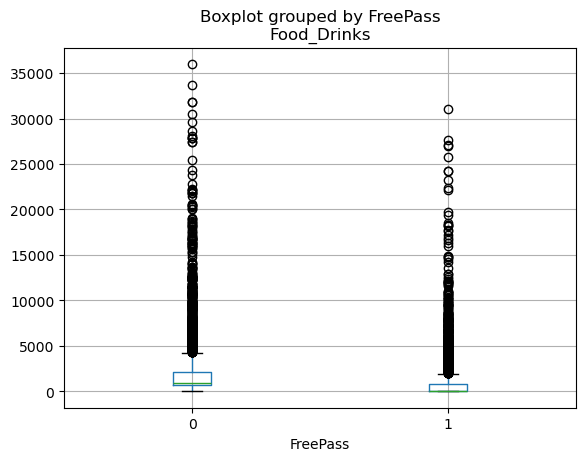

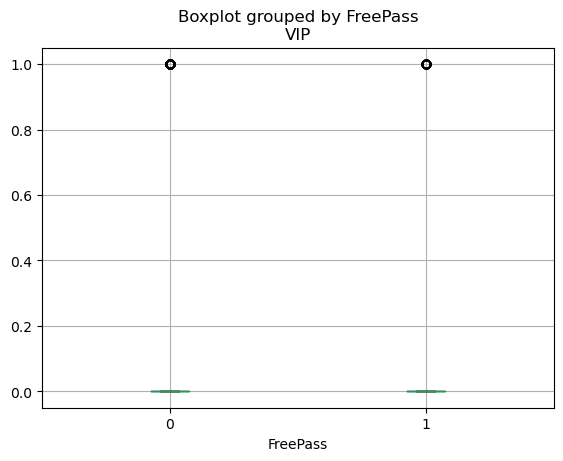

In [197]:
pd.crosstab(X_fe['Age_Group'], y, normalize='index')

pd.crosstab(X_fe['VIP'],y, normalize='index')

comp=X_fe.copy()

comp['FreePass'] = y

comp.groupby('FreePass')['Spending'].describe()
comp.boxplot(column='Food_Drinks', by='FreePass')
comp.boxplot(column='VIP', by='FreePass')

comp.groupby('FreePass')['VIP'].describe()


#y.info()

In [203]:

comp.groupby('Is_Young')['FreePass'].mean()

comp['minor']= (comp['Age'] < 5).astype(int)

comp.groupby('Is_VIP_Zone')['FreePass'].mean()

Is_VIP_Zone
0    0.515619
Name: FreePass, dtype: float64

In [195]:
menores = comp[comp['minor'] == 1]
menores['FreePass'].value_counts()



FreePass
1    1115
0     614
Name: count, dtype: int64

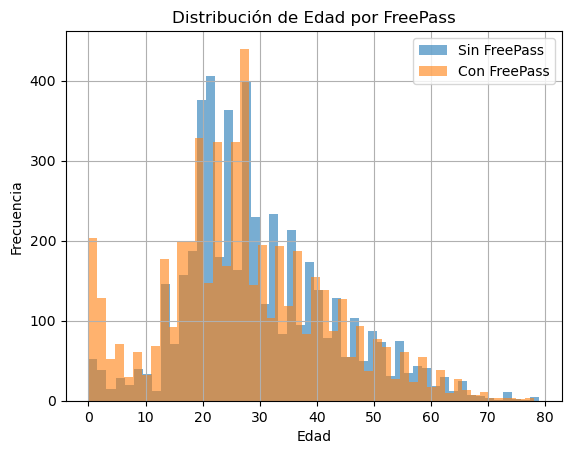

In [208]:
import matplotlib.pyplot as plt

comp[comp['FreePass']==0]['Age'].hist(alpha=0.6, bins=50)
comp[comp['FreePass']==1]['Age'].hist(alpha=0.6, bins=50)

plt.legend(['Sin FreePass', 'Con FreePass'])
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Distribución de Edad por FreePass')
plt.show()

